In [75]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [76]:
status = pd.read_csv("echidna_clone_status.8.1.24.csv", index_col=0).dropna().T
status.columns = ["echid_status_8.1.24"]

In [77]:
ip = pd.read_csv("var_exp_mt.csv", index_col=0).dropna()

In [5]:
adata = sc.read_h5ad("all_patients_anndata_Regressed.h5")

In [79]:
import os
all_delta_eta = pd.DataFrame()
eta_mode = pd.read_csv("all_patient_neutral_values.csv", index_col=0)
PATH = "params_mt_refined/samples/"
for patient in os.listdir(PATH):
    if "_" not in patient:
        print(patient)
        eta = pd.read_csv("params_mt_refined/samples/"+patient+"/eta.csv", index_col=0)
        delta_eta = pd.DataFrame()
        for cluster in eta.columns:
            delta_eta[patient+"_"+cluster]=np.asarray(eta[cluster])-eta_mode[patient+"_"+cluster][0]
        delta_eta.index = eta.index
        all_delta_eta = pd.concat((all_delta_eta, delta_eta),axis=1)

F16
F03
F02
F12
R310
R319
F01


In [68]:
PATH = "params_mt_refined/samples/"
all_ads = []
for patient in os.listdir(PATH):
    if "_" not in patient:
        print(patient)
        X = sc.read_h5ad(PATH+patient+"/X.h5")
        X.X = X.layers["counts"]
        all_ads.append(X)

F16
F03
F02


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


F12
R310
R319
F01


In [69]:
adata_nr = all_ads[0].concatenate(all_ads[1:])

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_30635/1565567718.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_nr = all_ads[0].concatenate(all_ads[1:])
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/_core/merge.py:1279: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_name

In [70]:
adata_nr.X = adata_nr.layers["counts"]


In [71]:
df = adata_nr.to_df()
var = pd.DataFrame(df.var())
thres = np.quantile(var[0],0.75)
var_filter = var[var[0]>thres].index

adata_nr = adata_nr[:,var_filter]

In [46]:
adata_nr.obs_names_make_unique()

In [56]:
sc.pp.calculate_qc_metrics(adata_nr, inplace=True)
adata_nr.layers["counts"] = adata_nr.X
# UPDATE OBS WITH USE

# store the current 'total_counts' under original_total_counts, which will not automatically be updated
# by scanpy in subsequent filtering steps
adata_nr.obs['original_total_counts'] = adata_nr.obs['total_counts']

# log10 original library size
adata_nr.obs['log10_original_total_counts'] = np.log10(adata_nr.obs['original_total_counts'])

# Normalize by median library size
med = np.median(adata_nr.obs['original_total_counts'])
sc.pp.normalize_total(adata_nr, target_sum = med)
sc.pp.log1p(adata_nr)

In [44]:
adata_nr.obs = adata_nr.obs.drop("inkt_evidence",axis=1)
adata_nr.write_h5ad("adata_no_regress_norm_togeter.h5")

In [57]:
sc.pp.neighbors(adata_nr)
sc.tl.umap(adata_nr)

# IP enrichments

In [222]:
ip_scores_r310 = all_delta_eta[[i for i in ip.columns if "R310" in i]]

In [223]:
ip_scores_r310 = ip_scores_r310.loc[ip.index]

In [100]:
r310_ad = sc.read_h5ad("params_mt_refined/samples/R310/X.h5")

In [224]:
df = r310_ad.to_df()
var = pd.DataFrame(df.var())

In [225]:
var = var.loc[ip_scores_r310.index]

In [226]:
var_filter = var.sort_values(by=0, ascending=False).iloc[0:5000].index

In [227]:
filtered = np.intersect1d(ip.index,np.unique(filtered))

In [228]:
filtered_data = ip.loc[filtered]
filtered_data["gene"]=filtered

In [365]:
import tqdm


def calculate_es(data, genes_of_interest):
    data_sorted = data.sort_values(by='rank')
    hits = data_sorted['gene'].isin(genes_of_interest).astype(int)
    non_hits = 1 - hits
    Nh = hits.sum()
    Nm = non_hits.sum()
    
    # sum of hits vs non hits so if enriched hits should rank towards the top
    Phit = np.cumsum(hits / Nh) if Nh != 0 else np.cumsum(hits)
    Pmiss = np.cumsum(non_hits / Nm) if Nm != 0 else np.cumsum(non_hits)
    
    running_sum = Phit - Pmiss
    ES = running_sum.max()
    
    return ES

def permutation_test_es(data, cluster, genes_of_interest, n_permutations=10000):
    cluster_data = data[data['cluster'] == cluster].copy()
    observed_es = calculate_es(cluster_data, genes_of_interest)
    
    perm_es = np.zeros(n_permutations)
    for i in tqdm.tqdm(range(n_permutations)):
        permuted_genes = np.random.permutation(cluster_data['gene'])
        permuted_data = cluster_data.assign(gene=permuted_genes)
        perm_es[i] = calculate_es(permuted_data, genes_of_interest)
    
    # Use a more robust method to calculate p-values
    p_value = (np.sum(perm_es >= observed_es) + 1) / (n_permutations + 1)
    return observed_es, p_value, perm_es.std()

from statsmodels.stats.multitest import multipletests
def fdr_correction(p_values, alpha=0.05):
    # Add small random noise to p-values to reduce ties
    noise = np.random.uniform(0, 1e-10, size=p_values.shape)
    p_values_noisy = p_values + noise
    
    # Apply FDR-BH correction
    rejected, pvals_corrected, _, _ = multipletests(p_values_noisy, alpha=alpha, method='fdr_bh')
    return pd.Series(pvals_corrected, index=p_values.index)


data_long = filtered_data.melt(id_vars=['gene'], var_name='cluster', value_name='score')

# Rank genes within each cluster
data_long['rank'] = data_long.groupby('cluster')['score'].rank(ascending=False)

sigs_nes = {}
for s in vis_nes.columns:
    print(s)
    sig = [i for i in wouters[s] if not pd.isna(i)]
    subset_genes_high = list(set(filtered_data['gene'].unique()).intersection(set(list(sig))))
    results = []
    for cluster in data_long['cluster'].unique():
        es, p_value, std = permutation_test_es(data_long, cluster, subset_genes_high, n_permutations=1000)
        results.append({'cluster': cluster, 'enrichment_score': es, 'p_value': p_value, 'std': std})
    
        results_df = pd.DataFrame(results)
        results_df['p_value_adj'] = fdr_correction(results_df['p_value'], alpha=0.05)
    sigs_nes[s] = results_df

rambow_mitosis


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1070.73it/s]


rambow_invasion


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1146.54it/s]


rambow_immune


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1086.88it/s]


rambow_MITF_targets


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1111.51it/s]


ALONSO_METASTASIS_EMT_UP


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1105.13it/s]


ALONSO_METASTASIS_UP


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1049.17it/s]


SARRIO_EPITHELIAL_MESENCHYMAL_TRANSITION_UP


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 991.48it/s]


AXL_SIGNATURE_GODING


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1038.75it/s]


HOEK_PRO


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 964.28it/s]


JEFFS_PRO


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 972.07it/s]


LEE_NEURAL_CREST_STEM_CELL_UP


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1055.84it/s]


MITF_targets


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 931.98it/s]


SOX10_targets


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 913.55it/s]


VERF_PRO


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 933.37it/s]


WU_CELL_MIGRATION


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1056.94it/s]


cheng_mitotic_top100


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1041.23it/s]


hugo_IPRES


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1014.11it/s]


HALLMARK_ADIPOGENESIS


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1032.49it/s]


HALLMARK_ALLOGRAFT_REJECTION


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 919.18it/s]


HALLMARK_ANGIOGENESIS


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1059.75it/s]


HALLMARK_APICAL_JUNCTION


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1036.74it/s]


HALLMARK_APOPTOSIS


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1054.87it/s]


HALLMARK_COAGULATION


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1008.28it/s]


HALLMARK_E2F_TARGETS


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 928.00it/s]


HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1003.76it/s]


HALLMARK_ESTROGEN_RESPONSE_EARLY


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1032.61it/s]


HALLMARK_FATTY_ACID_METABOLISM


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1008.82it/s]


HALLMARK_G2M_CHECKPOINT


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 984.17it/s]


HALLMARK_GLYCOLYSIS


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1037.59it/s]


HALLMARK_HYPOXIA


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 998.43it/s]


HALLMARK_INTERFERON_ALPHA_RESPONSE


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 962.75it/s]


HALLMARK_INTERFERON_GAMMA_RESPONSE


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1086.47it/s]


HALLMARK_MTORC1_SIGNALING


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1012.54it/s]


HALLMARK_MYC_TARGETS_V1


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1112.33it/s]


HALLMARK_MYC_TARGETS_V2


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 901.35it/s]


HALLMARK_MYOGENESIS


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1145.86it/s]


HALLMARK_OXIDATIVE_PHOSPHORYLATION


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 992.44it/s]


HALLMARK_P53_PATHWAY


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1147.92it/s]


HALLMARK_PEROXISOME


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1133.22it/s]


HALLMARK_PROTEIN_SECRETION


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1129.40it/s]


HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1124.72it/s]


HALLMARK_UNFOLDED_PROTEIN_RESPONSE


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1149.15it/s]


HALLMARK_UV_RESPONSE_UP


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1028.90it/s]


HALLMARK_XENOBIOTIC_METABOLISM


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1034.97it/s]


HARRIS_HYPOXIA


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1067.41it/s]


JEON_SMAD6_TARGETS_DN


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1049.97it/s]


HKG_Chang_etal_PlosOne_2011


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1050.53it/s]


HKG_Eisenberg_etal_TIG_2013


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1041.23it/s]


MINN_PRO


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 941.94it/s]


SEMI_9PROvs2SEMI


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1058.77it/s]


XU_INV


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1006.62it/s]


XU_PRO


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1034.62it/s]


Baron_Mature_melanocytes


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1010.64it/s]


Baron_Neural_crest


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1063.73it/s]


Baron_Stress_like


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1133.42it/s]


Tirosh_AXL_sig


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1115.66it/s]


Tirosh_MITF_sig


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1047.40it/s]


Wouters_Intermediate_cell_state


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1143.10it/s]


Wouters_Mesenchymal_like_cell_state


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 964.02it/s]


Wouters_Melanocytic_cell_state


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1045.59it/s]


jerby_resistance_up


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1007.88it/s]


jerby_resistance_down


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 999.13it/s]


CIN70


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1072.29it/s]


INVASIVE_rambow


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1108.13it/s]


HYPERdiff_rambow


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1029.75it/s]


mesenchymal_vs_CAF_pozniak


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1052.28it/s]


Anitgen_pres_pozniak


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1108.05it/s]


Interferon_a_b_response_pozniak


100%|██████████████████████████████████████████| 1000/1000 [00:01<00:00, 862.47it/s]


Melanocytic_pozniak


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1090.67it/s]


Mesenchymal_like_pozniak


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1041.13it/s]


Neural_Crest_like_pozniak


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1103.15it/s]


Stress_hypoxia_pozniak


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1140.31it/s]


Stress_p53_pozniak


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1056.17it/s]


Immune_resistance_wang


100%|█████████████████████████████████████████| 1000/1000 [00:00<00:00, 1007.74it/s]


In [366]:
import pickle
filehandler = open("IP_nes_cohort.pickle","wb")
pickle.dump(sigs_nes,filehandler)

In [229]:
import pickle
with open('IP_nes.pickle', 'rb') as file:
    sigs_nes = pickle.load(file)

In [230]:
trim_nes = {}
for key in sigs_nes.keys():
    for i in sigs_nes[key].p_value_adj:
        if i<.05:
            trim_nes[key]=sigs_nes[key]
            break

In [232]:
trim_nes_cohort = {}
for key in sigs_nes:
    for i in sigs_nes[key].p_value_adj:
        if i<.05:
            trim_nes_cohort[key]=sigs_nes[key]
            break

In [292]:
vis_nes = pd.DataFrame()
for key in trim_nes.keys():
    vis_nes[key]=trim_nes[key].enrichment_score

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_30635/2044933128.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vis_nes[key]=trim_nes[key].enrichment_score
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_30635/2044933128.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vis_nes[key]=trim_nes[key].enrichment_score
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_30635/2044933128.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

In [293]:
vis_nes.index = trim_nes_cohort[key]["cluster"]

In [295]:
vis_nes = vis_nes[[i for i in vis_nes.columns if (("KEGG" not in i) or ("ANTIGEN" in i))]]

In [278]:
mean = pd.DataFrame()
df = r310_ad.to_df()
for s in vis_nes.columns:
    sig = [i for i in wouters[s] if (not pd.isna(i)) and (i in ip_scores_r310.index)]
    mean[s] = df[sig].mean(axis=1)

In [279]:
obs = r310_ad.obs
clust_mean = pd.DataFrame()
for clust in obs["leiden"]:
    clust_mean[clust] = mean.loc[obs[obs["leiden"]==clust].index].mean(axis=0)

In [280]:
clust_mean.columns = ["R310_"+i for i in clust_mean.columns]

In [281]:
pal = {"growing":"red","shrinking":"green","stable":"yellow"}
colors = [pal[status.loc[i]["echid_status_8.1.24"]] for i in clust_mean.columns]

In [285]:
spell = []
for i in clust_mean.index:
    if "Anitgen" in i:
        spell.append("Antigen_pres_pozniak")
    else:
        spell.append(i)
clust_mean.index = spell

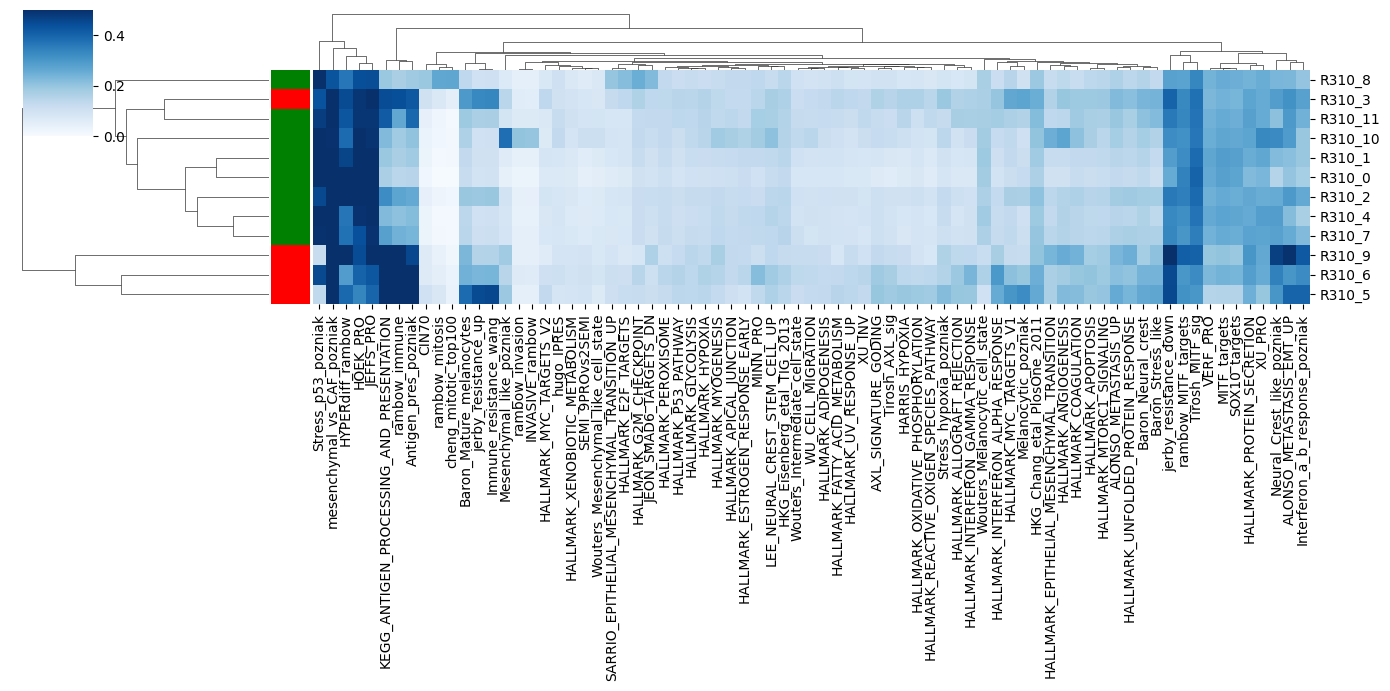

In [286]:
sns.clustermap(clust_mean.T,xticklabels=True, cmap='Blues', figsize=(14,7), row_colors=colors,vmin=0,vmax=.5)
plt.savefig("FIGURES/exp_enrichments.pdf", dpi=300)

In [296]:
mean = pd.DataFrame()
for s in vis_nes.columns:
    sig = [i for i in wouters[s] if (not pd.isna(i)) and (i in ip.index)]
    mean[s] = ip_scores_r310.loc[sig].mean(axis=0)


In [297]:
plot = np.sign(mean)*np.asarray(vis_nes)

In [298]:
pal = {"growing":"red","shrinking":"green","stable":"yellow"}
colors = [pal[status.loc[i]["echid_status_8.1.24"]] for i in plot.index]

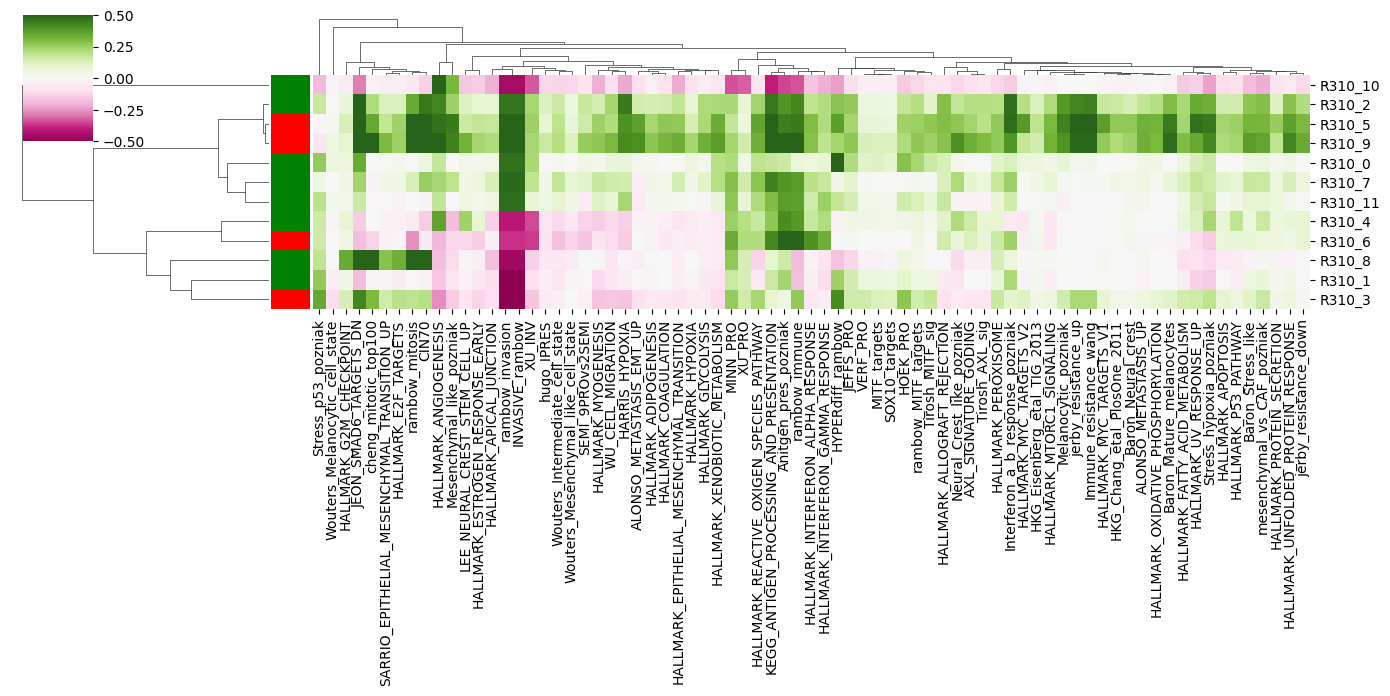

In [302]:
sns.clustermap(plot, figsize=(14,7),xticklabels=True, cmap='PiYG', metric='cosine', row_colors=colors, vmin=-.5, vmax=.5)
plt.savefig("FIGURES/IP_enrichments.pdf", dpi=300)